In [1]:
import os
import numpy as np
import pandas as pd
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.models.damp import DAMP
from TSB_UAD.vus.metrics import get_metrics
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.imondrian.mondrianforest import MondrianForest
from TSB_UAD.models.sand import SAND
from sklearn.preprocessing import MinMaxScaler
import math 
from TSB_UAD.vus import metrics

# Read data -- create/read a normality-2 dataset named `combined.csv`
# filepath = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts1 = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts2 = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_20.out"
# df = pd.read_csv(filepath, header=None).dropna().to_numpy()

# filepath = 'MBA_ECG14046_data_9_20.csv'
filepath = 'data/benchmark/ECG/MBA_ECG805_data.out'
name = filepath.split('/')[-1]
if not os.path.exists(filepath):
    df1 = pd.read_csv(ts1, header=None).dropna().to_numpy()
    df2 = pd.read_csv(ts2, header=None).dropna().to_numpy()
    combined = np.vstack((df1, df2))
    pd.DataFrame(combined).to_csv(filepath, header=False, index=False)

df = pd.read_csv(filepath, header=None).dropna().to_numpy()
data = df[:, 0].astype(float)
labels = df[:, 1].astype(int)


/home/lazaros/Documents/ΑΠΘ/msc/2ο εξαμηνο/MMDS/project/TSB-UAD/TSB_UAD/models/imondrian/mondrianforest.py:64: UserWarning: pydot not loaded: tree will not be printed; set draw_mondrian=0
  warn('pydot not loaded: tree will not be printed; set draw_mondrian=0')


In [2]:
# Preprocessing
# slidingWindow = 10 # user defined

# or auto sliding window length
slidingWindow = find_length(data)
X_data = Window(window=slidingWindow).convert(data).to_numpy()
print(X_data.shape, data.shape)
# Mondrian Forest: ετρεξε κομπλε
# [5000, 1] -> [256, 1]
# MF: δεν τρεχει
# [5000, 96] -> [256, 96] # sliding windows

(230302, 99) (230400,)


In [3]:
def evaluate(score, modelName, slidingWindow, name, predict=True):
    from TSB_UAD.vus import metrics
    from importlib import reload
    metrics = reload(metrics)
    # post processing
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    if predict:
        score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
    for metric in results.keys():
        print(metric, ":", results[metric])
    plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

In [8]:
print('sliding window:',X_data[0][::-1], '\nregular data:', data[:-96])
# print(np.allclose(X_data[0][::-1], data[:96]))

sliding window: [-0.02  0.    0.    0.01 -0.02  0.01 -0.01  0.02  0.    0.03  0.01  0.02  0.03  0.03  0.02  0.02  0.01  0.01  0.01 -0.04  0.   -0.03 -0.03 -0.06 -0.05 -0.06 -0.06 -0.08 -0.07 -0.09 -0.1  -0.1  -0.1
 -0.09 -0.04 -0.04 -0.02  0.01  0.03  0.06 -0.05 -0.06 -0.16 -0.2  -0.18 -0.16 -0.15 -0.16 -0.14 -0.17 -0.12  0.24  0.47 -0.02 -2.12 -2.15 -1.46 -0.89 -0.38 -0.02 -0.03  0.01  0.03  0.08  0.07  0.11
  0.11  0.14  0.14  0.17  0.18  0.2   0.26  0.27  0.31  0.32  0.39  0.41  0.48  0.49  0.54  0.51  0.52  0.48  0.46  0.37  0.29  0.21  0.13  0.08  0.03  0.02 -0.01  0.   -0.02 -0.02] 
regular data: [-0.02  0.    0.   ... -0.08 -0.08 -0.08]


AUC_ROC : 0.9240843702602897
AUC_PR : 0.7010192438503529
Precision : 0.8078664769051623
Recall : 0.3091089108910891
F : 0.4471338035733467
Precision_at_k : 0.3091089108910891
Rprecision : 0.7483076459586213
Rrecall : 0.2331372358745125
RF : 0.3555133444411152
R_AUC_ROC : 0.9830329132349354
R_AUC_PR : 0.9160149571050958
VUS_ROC : 0.9852653141918912
VUS_PR : 0.9056259404590042
Affiliation_Precision : 0.957507957075365
Affiliation_Recall : 0.9886291182066647


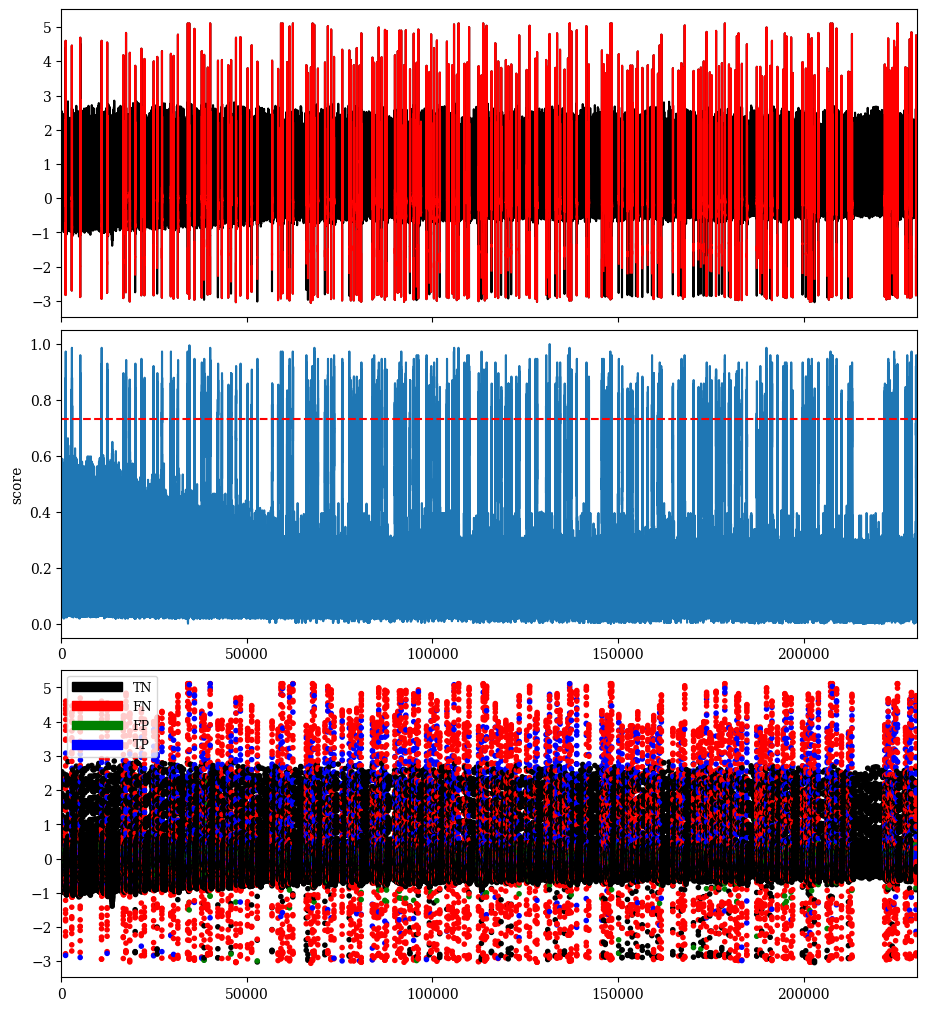

In [4]:
# Run offline Isolation Forest
modelName = 'IForest'
clf = IForest(n_jobs=1, n_estimators=10, max_samples=3*46)
x = X_data
# x = data
labels = labels
clf.fit(x)
score = clf.decision_scores_
# post processing
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
# if predict:
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ":", results[metric])
plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

0-->5000-->10000-->15000-->20000-->25000-->30000-->35000-->40000-->45000-->50000-->55000-->60000-->65000-->70000-->75000-->80000-->85000-->90000-->95000-->100000-->105000-->110000-->115000-->120000-->125000-->130000-->135000-->140000-->145000-->150000-->155000-->160000-->165000-->170000-->175000-->180000-->185000-->190000-->195000-->200000-->205000-->210000-->215000-->220000-->225000-->230000-->AUC_ROC : 0.9276971426317228
AUC_PR : 0.6340168018092321
Precision : 0.7189170742805142
Recall : 0.31287128712871287
F : 0.43599737849677483
Precision_at_k : 0.31287128712871287
Rprecision : 0.6963871055874378
Rrecall : 0.23911764706017163
RF : 0.3559970073050744
R_AUC_ROC : 0.9747098678375511
R_AUC_PR : 0.8898770050119177
VUS_ROC : 0.983421596163742
VUS_PR : 0.8735823202277413
Affiliation_Precision : 0.9639899819353125
Affiliation_Recall : 0.977389768605449


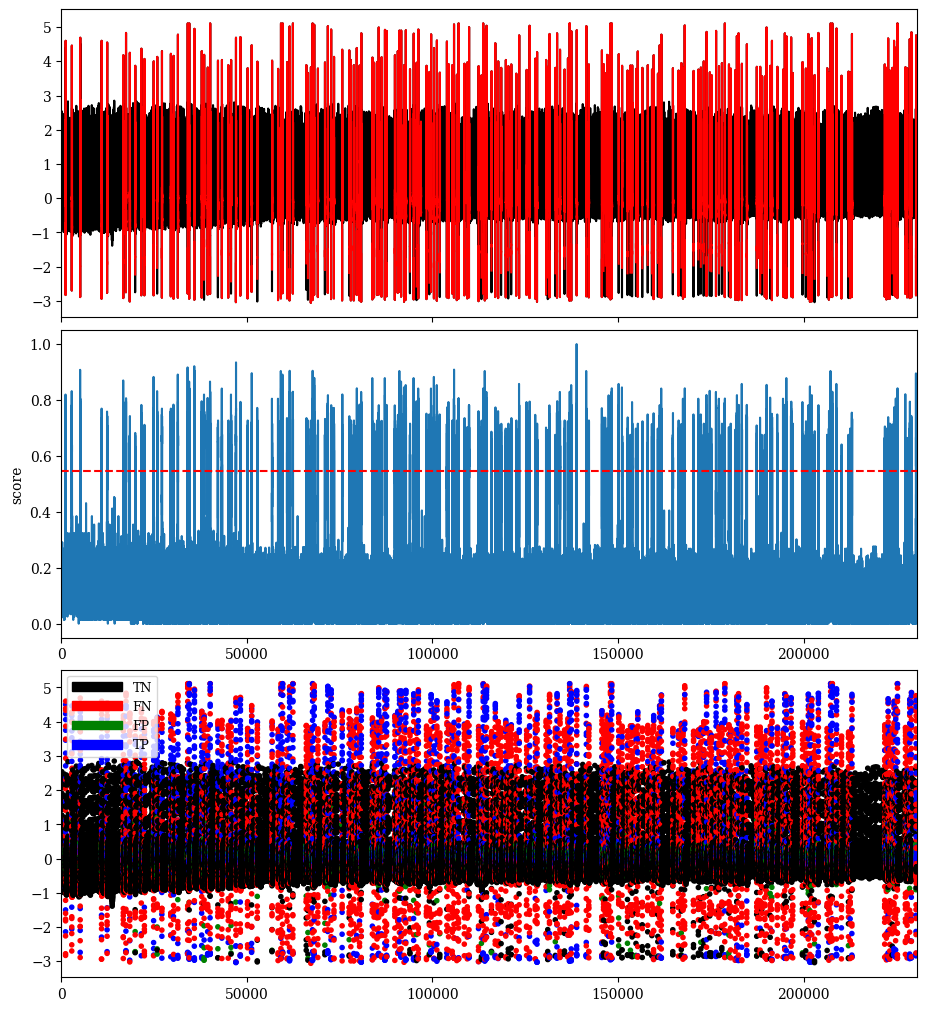

In [ ]:
# Run online Isolation Forest (variant 1)
modelName = 'IForest'
clf = IForest(n_jobs=1,n_estimators=10, max_samples=3*46)
x = X_data
clf.fit(x, online=True, verbose=True, batch_size=5_000) # runs in 1.5 minutes
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

0-->5000-->10000-->15000-->20000-->25000-->30000-->35000-->40000-->45000-->50000-->55000-->60000-->65000-->70000-->75000-->80000-->85000-->90000-->95000-->100000-->105000-->110000-->115000-->120000-->125000-->130000-->135000-->140000-->145000-->150000-->155000-->160000-->165000-->170000-->175000-->180000-->185000-->190000-->195000-->200000-->205000-->210000-->215000-->220000-->225000-->230000-->AUC_ROC : 0.7305456818588614
AUC_PR : 0.2430713684627159
Precision : 0.9653179190751445
Recall : 0.04133663366336634
F : 0.07927842392594352
Precision_at_k : 0.04133663366336634
Rprecision : 0.9329896907216495
Rrecall : 0.2065476615071149
RF : 0.3382194334426991
R_AUC_ROC : 0.743027348461508
R_AUC_PR : 0.3468159737549721
VUS_ROC : 0.7886856480260497
VUS_PR : 0.2610539652883577
Affiliation_Precision : 0.627413384444606
Affiliation_Recall : 0.9921143501302261


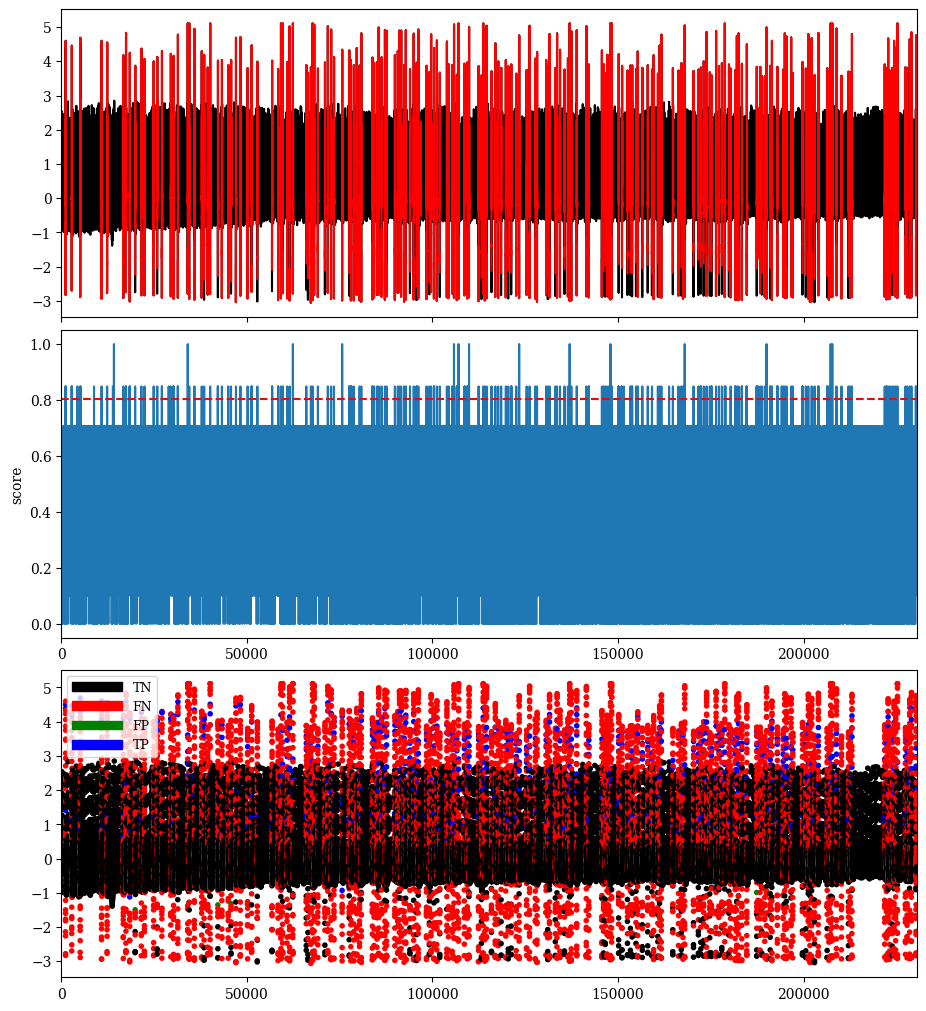

In [6]:
# Run online Isolation Forest (variant 1 3 samples only)
modelName = 'IForest'
clf = IForest(n_jobs=1,n_estimators=10, max_samples=3)
x = X_data
clf.fit(x, online=True, verbose=True, batch_size=5_000) # runs in 1.5 minutes
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

In [ ]:
# Run online Isolation Forest (variant 2)
modelName = 'IForest (online variant 2)'
clf = IForest(n_jobs=1, n_estimators=10)
x = X_data
clf.fit(X=x, y=labels, online=True, verbose=True, batch_size=5_000, variant=2)
score = clf.decision_scores_

# post processing
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
# if predict:
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ":", results[metric])
plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

Training on 230302 samples of dimension 99
0-->5000-->10000-->15000-->20000-->25000-->30000-->35000-->40000-->45000-->50000-->55000-->60000-->65000-->70000-->75000-->80000-->85000-->90000-->95000-->100000-->105000-->110000-->115000-->120000-->125000-->130000-->135000-->140000-->145000-->150000-->155000-->160000-->165000-->170000-->175000-->180000-->185000-->190000-->195000-->200000-->205000-->210000-->215000-->220000-->225000-->230000-->230302 [END]


ValueError: operands could not be broadcast together with shapes (119,) (52,) 

AUC_ROC : 0.9249075891889855
AUC_PR : 0.6525558868803655
Precision : 0.80187265917603
Recall : 0.10599009900990099
F : 0.18723218189768256
Precision_at_k : 0.10599009900990099
Rprecision : 0.744718042255662
Rrecall : 0.22949148093520202
RF : 0.35086178553590835
R_AUC_ROC : 0.9807569383361283
R_AUC_PR : 0.9116105117068753
VUS_ROC : 0.9831409056424443
VUS_PR : 0.8890091917597667
Affiliation_Precision : 0.8723946598690415
Affiliation_Recall : 0.9948501331002929


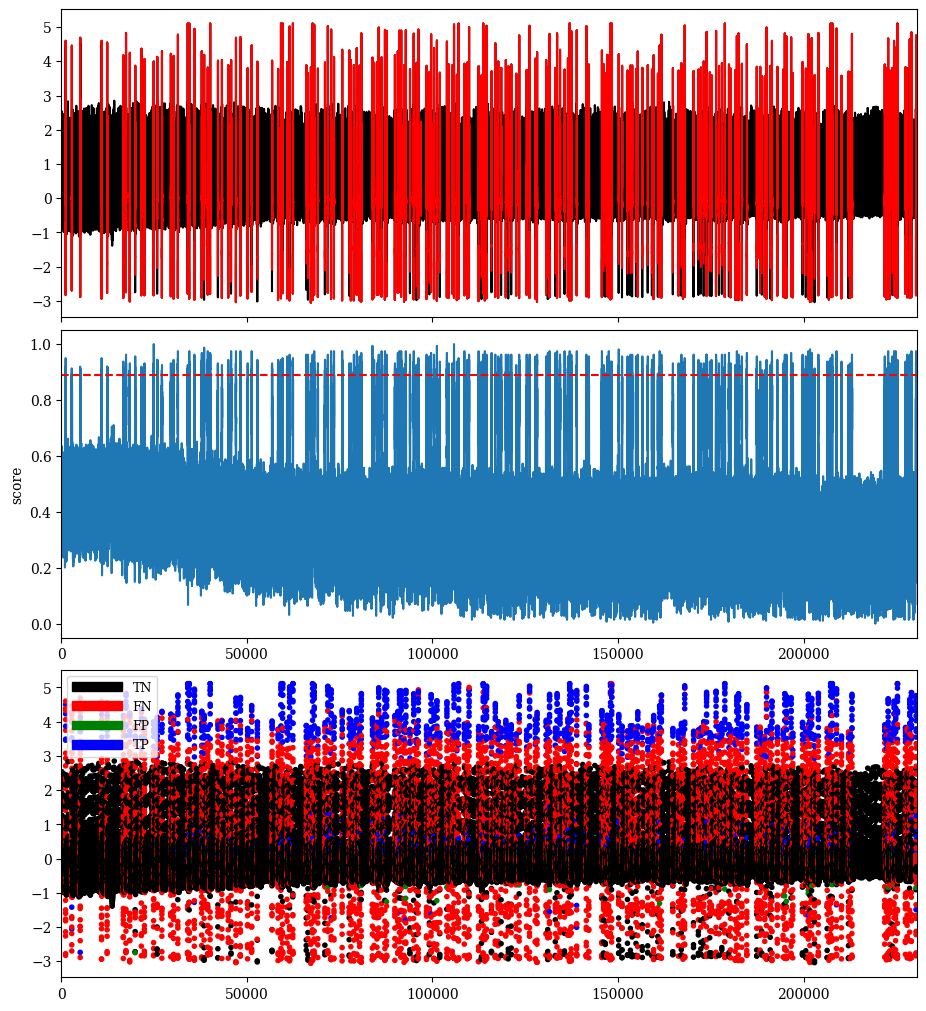

In [5]:
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ":", results[metric])
plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)